# 毕业论文`GRAD`
## `MCIP`气象场分析

---
*@author: Evan*\
*@date: 2023-11-04*

In [1]:
import os
import numpy as np
import pandas as pd

import sys
sys.path.append('../../../src/')
from namelist import *
from mask import average_data
from spatial import contourmap, map_diff

# silence the warning note
import warnings
warnings.filterwarnings("ignore")

In [2]:
sitelocation = pd.read_excel(obs_dir + 'sitelocation.xlsx')
sitelocation = sitelocation.iloc[:55,:]
site_group = sitelocation.groupby('城市')
city_site = {}
for group in site_group.groups:
    city_site[group] = site_group.get_group(group)['监测点编码'].values
city_site

{'东莞': array(['1387A', '1388A', '1389A', '1390A', '1391A'], dtype=object),
 '中山': array(['1379A', '1380A', '1381A', '1382A'], dtype=object),
 '佛山': array(['1371A', '1372A', '1373A', '1374A', '1375A', '1376A', '1377A',
        '1378A'], dtype=object),
 '广州': array(['1345A', '1346A', '1347A', '1348A', '1349A', '1350A', '1351A',
        '1352A', '1353A', '1354A', '1355A'], dtype=object),
 '惠州': array(['1392A', '1393A', '1394A', '1395A', '1396A'], dtype=object),
 '江门': array(['1383A', '1384A', '1385A', '1386A'], dtype=object),
 '深圳': array(['1356A', '1357A', '1358A', '1359A', '1360A', '1361A', '1362A',
        '1363A', '1364A', '1365A', '1366A'], dtype=object),
 '珠海': array(['1367A', '1368A', '1369A', '1370A'], dtype=object),
 '肇庆': array(['1397A', '1398A', '1399A'], dtype=object)}

In [3]:
sitenum = sitelocation['监测点编码'].values
sitelon = sitelocation['经度'].values
sitelat = sitelocation['纬度'].values

In [4]:
var = 'NO2'
month = "Sep"
obspath = get_obspath(month)

low_years = np.array([2016,2015,2014])
high_years = np.array([2022,2021,2019])

# =======================================
# Observation data
# =======================================

dfs = []
for year in low_years: 
    df = pd.read_excel(obspath + f'site_{var}_{year}.xlsx',index_col=0)
    df = df[sitenum].reset_index()
    df.drop(columns='index',inplace=True)
    dfs.append(df)
    
merged_df = pd.concat(dfs)
obs_low   = merged_df.groupby(level=0).mean()

dfs = []
for year in high_years: 
    df = pd.read_excel(obspath + f'site_{var}_{year}.xlsx',index_col=0)
    df = df[sitenum].reset_index()
    df.drop(columns='index',inplace=True)
    dfs.append(df)
    
merged_df = pd.concat(dfs)
obs_high  = merged_df.groupby(level=0).mean()

# =======================================
# Simulation data
# =======================================

low_files  = [os.path.join(processed_dir, f"{month}_{year}/{month}_{year}_chem.nc") for year in low_years]
high_files = [os.path.join(processed_dir, f"{month}_{year}/{month}_{year}_chem.nc") for year in high_years]
low_wind  = [os.path.join(processed_dir, f"{month}_{year}/{month}_{year}_mcip.nc") for year in low_years]
high_wind = [os.path.join(processed_dir, f"{month}_{year}/{month}_{year}_mcip.nc") for year in high_years]

sim_low     = average_data(low_files, var)
sim_high    = average_data(high_files, var)
sim_low_uw  = average_data(low_wind, 'uwind')
sim_high_uw = average_data(high_wind, 'uwind')
sim_low_vw  = average_data(low_wind, 'vwind')
sim_high_vw = average_data(high_wind, 'vwind')


In [5]:
obs_low.index = pd.date_range('2023-09-01T00','2023-09-30T23',freq='H')
obs_high.index = pd.date_range('2023-09-01T00','2023-09-30T23',freq='H')
avg_obs_low   = obs_low.mean(axis=0)
avg_obs_high   = obs_high.mean(axis=0)

avg_sim_low   = sim_low.mean(dim='time')
avg_sim_high  = sim_high.mean(dim='time')

uwind_low  = sim_low_uw.mean(dim='time')
uwind_high = sim_high_uw.mean(dim='time')
vwind_low  = sim_low_vw.mean(dim='time')
vwind_high = sim_high_vw.mean(dim='time')

In [6]:
cmin=0
cmax=100
cmstep=1
cbstep=20

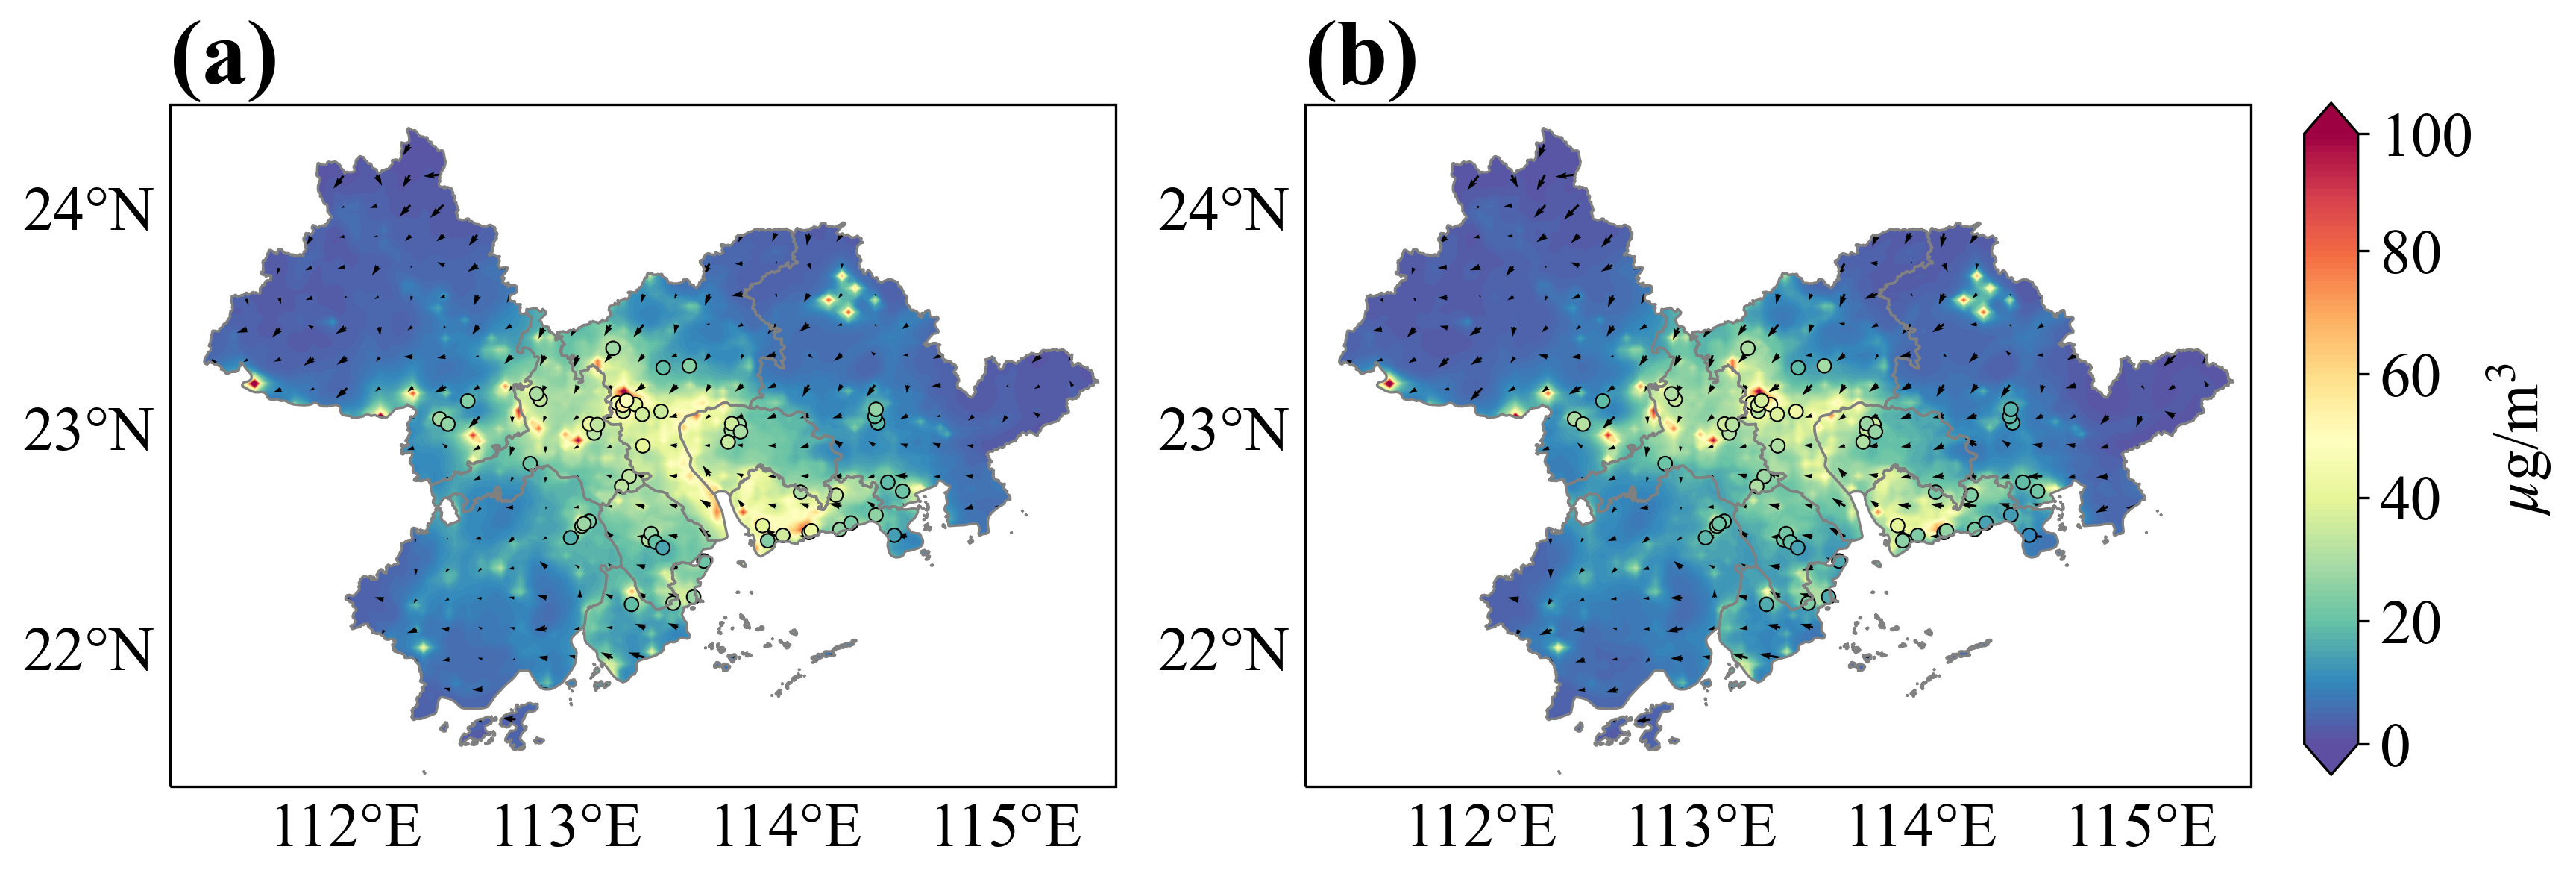

In [7]:
contourmap(sim_low, cmin, cmax, cmstep, cbstep,
             avg_sim_low, avg_sim_high, uwind_low, vwind_low, uwind_high, vwind_high,
             avg_obs_low,avg_obs_high, sitelon, sitelat,
             ngrid=5, scale=100, headwidth=3,
             colorbar_label='$\mu$g/m$^3$')

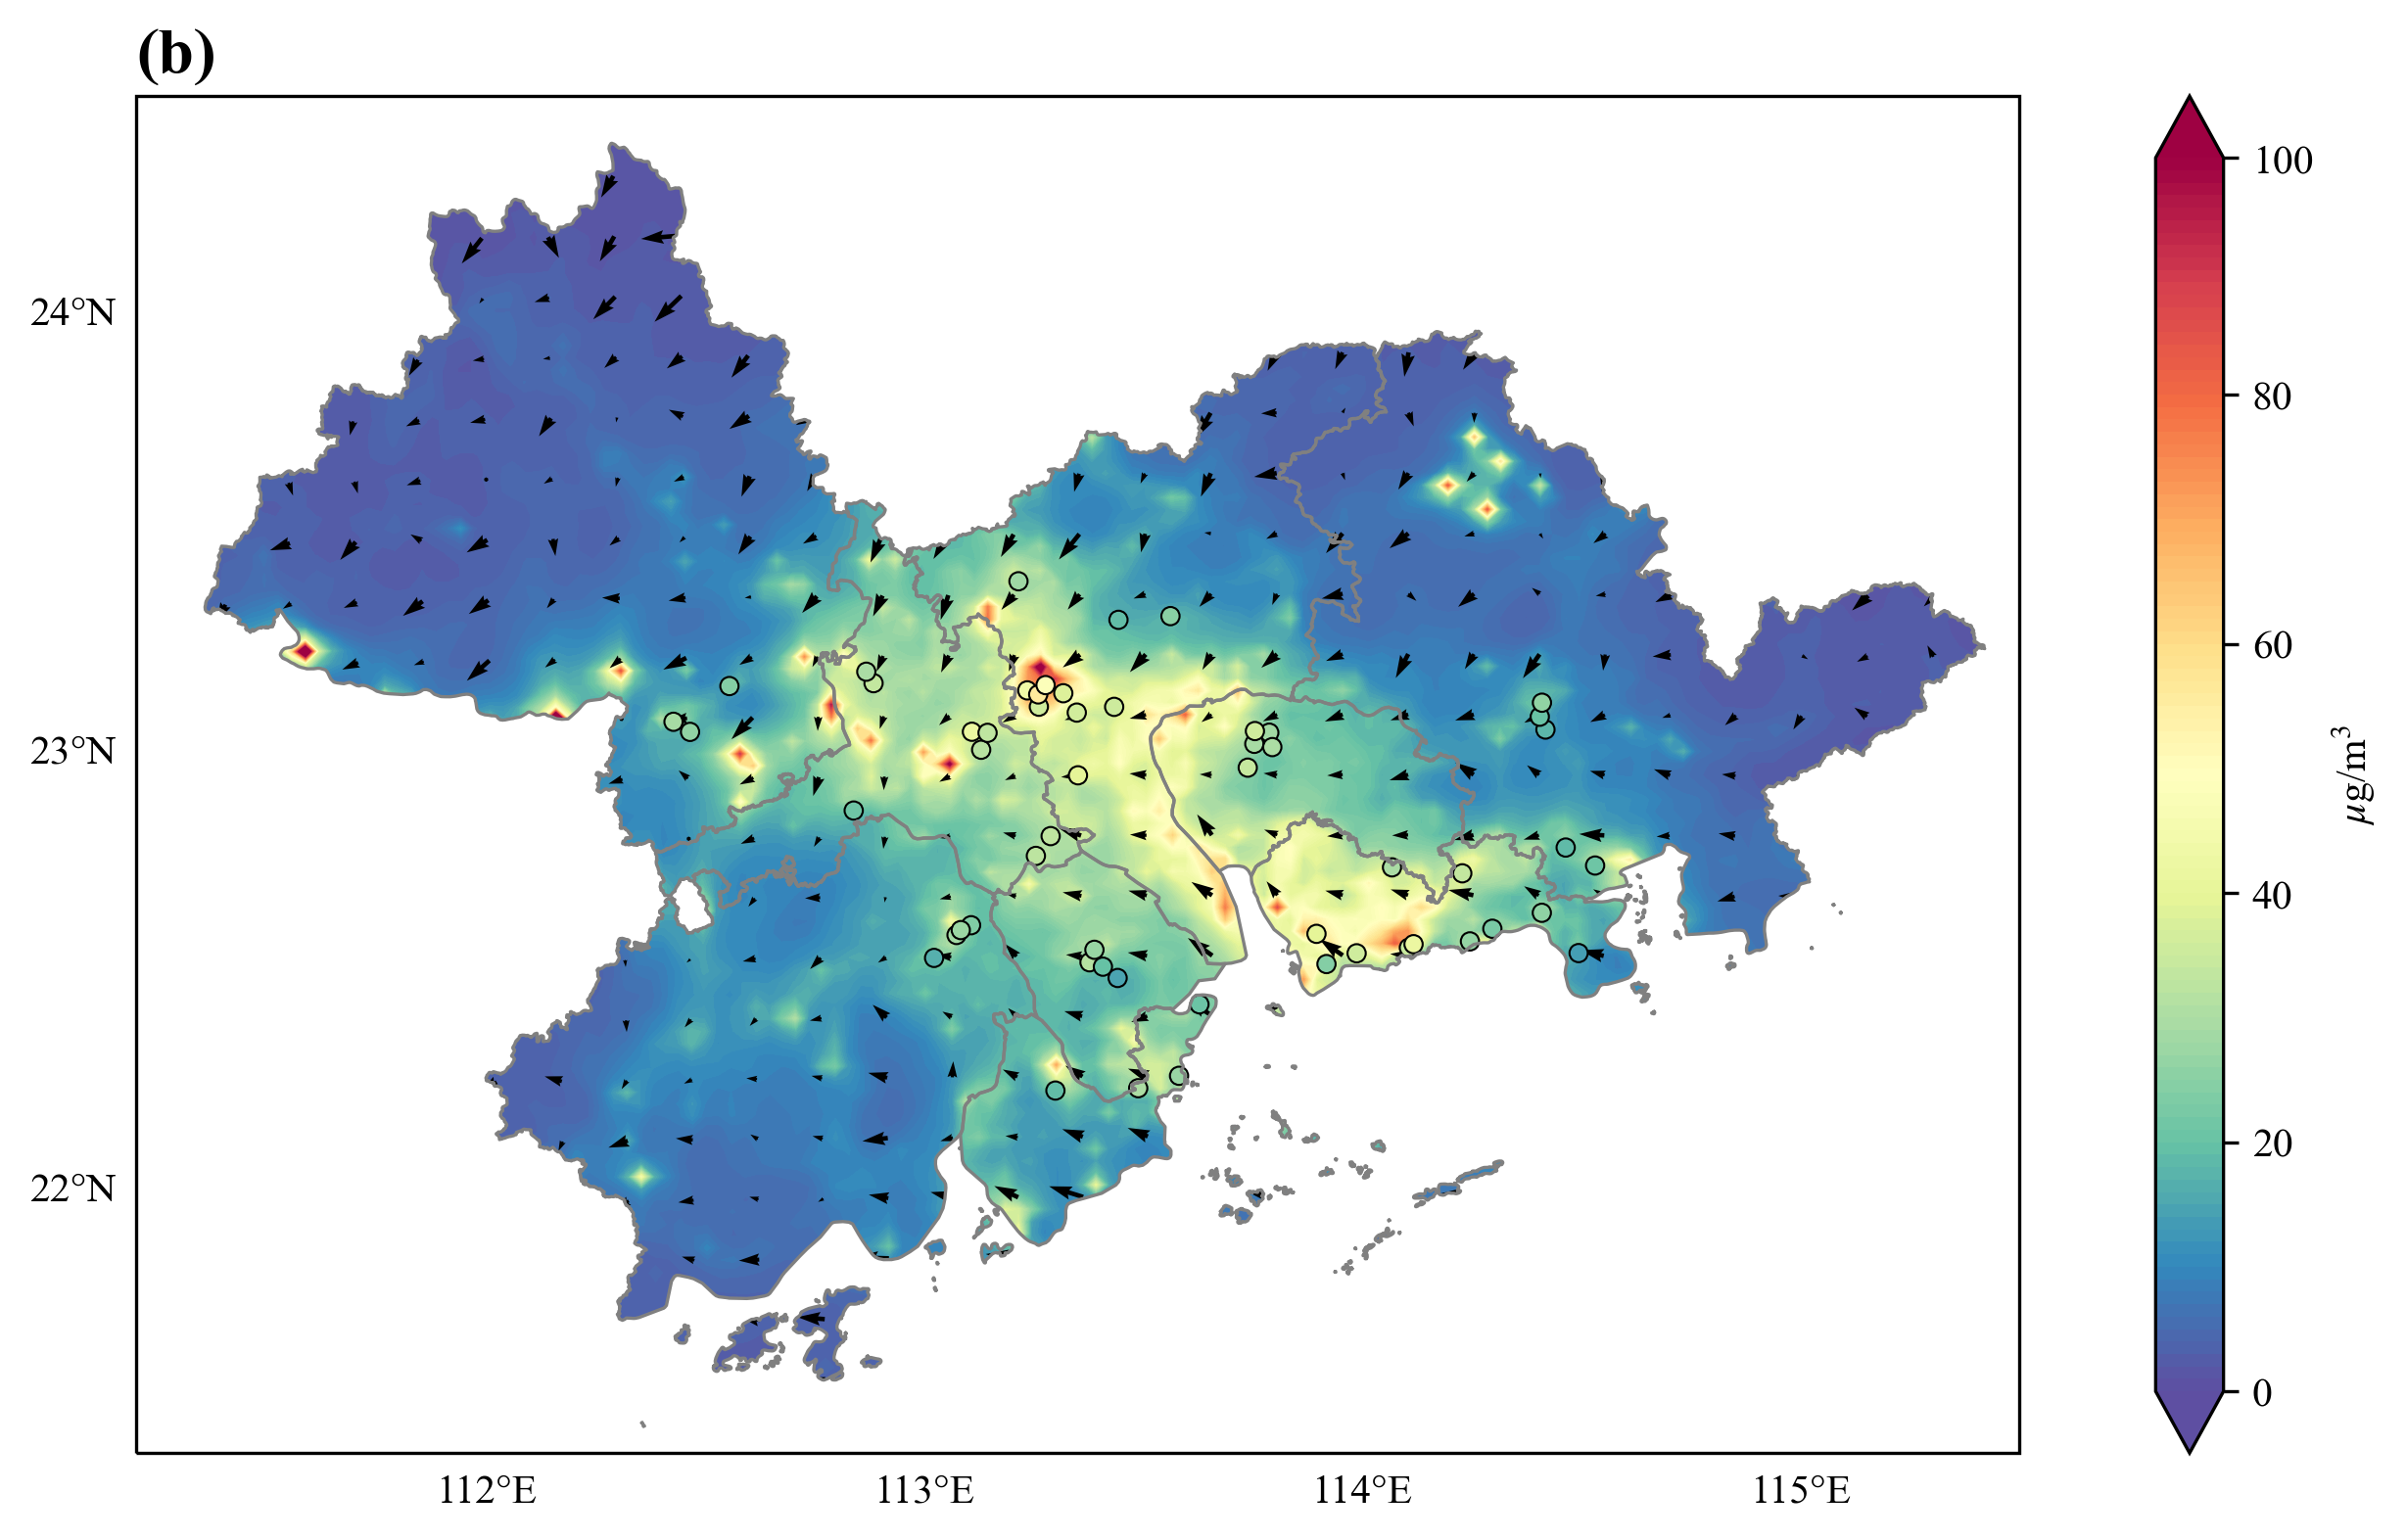

In [8]:
plot_map_withobs(sim_low, cmin, cmax, cmstep, cbstep,
             avg_sim_low, uwind_low, vwind_low,
             avg_obs_low, sitelon, sitelat,
             ngrid=5, scale=100, headwidth=3,
             title='(b)', colorbar_label='$\mu$g/m$^3$')

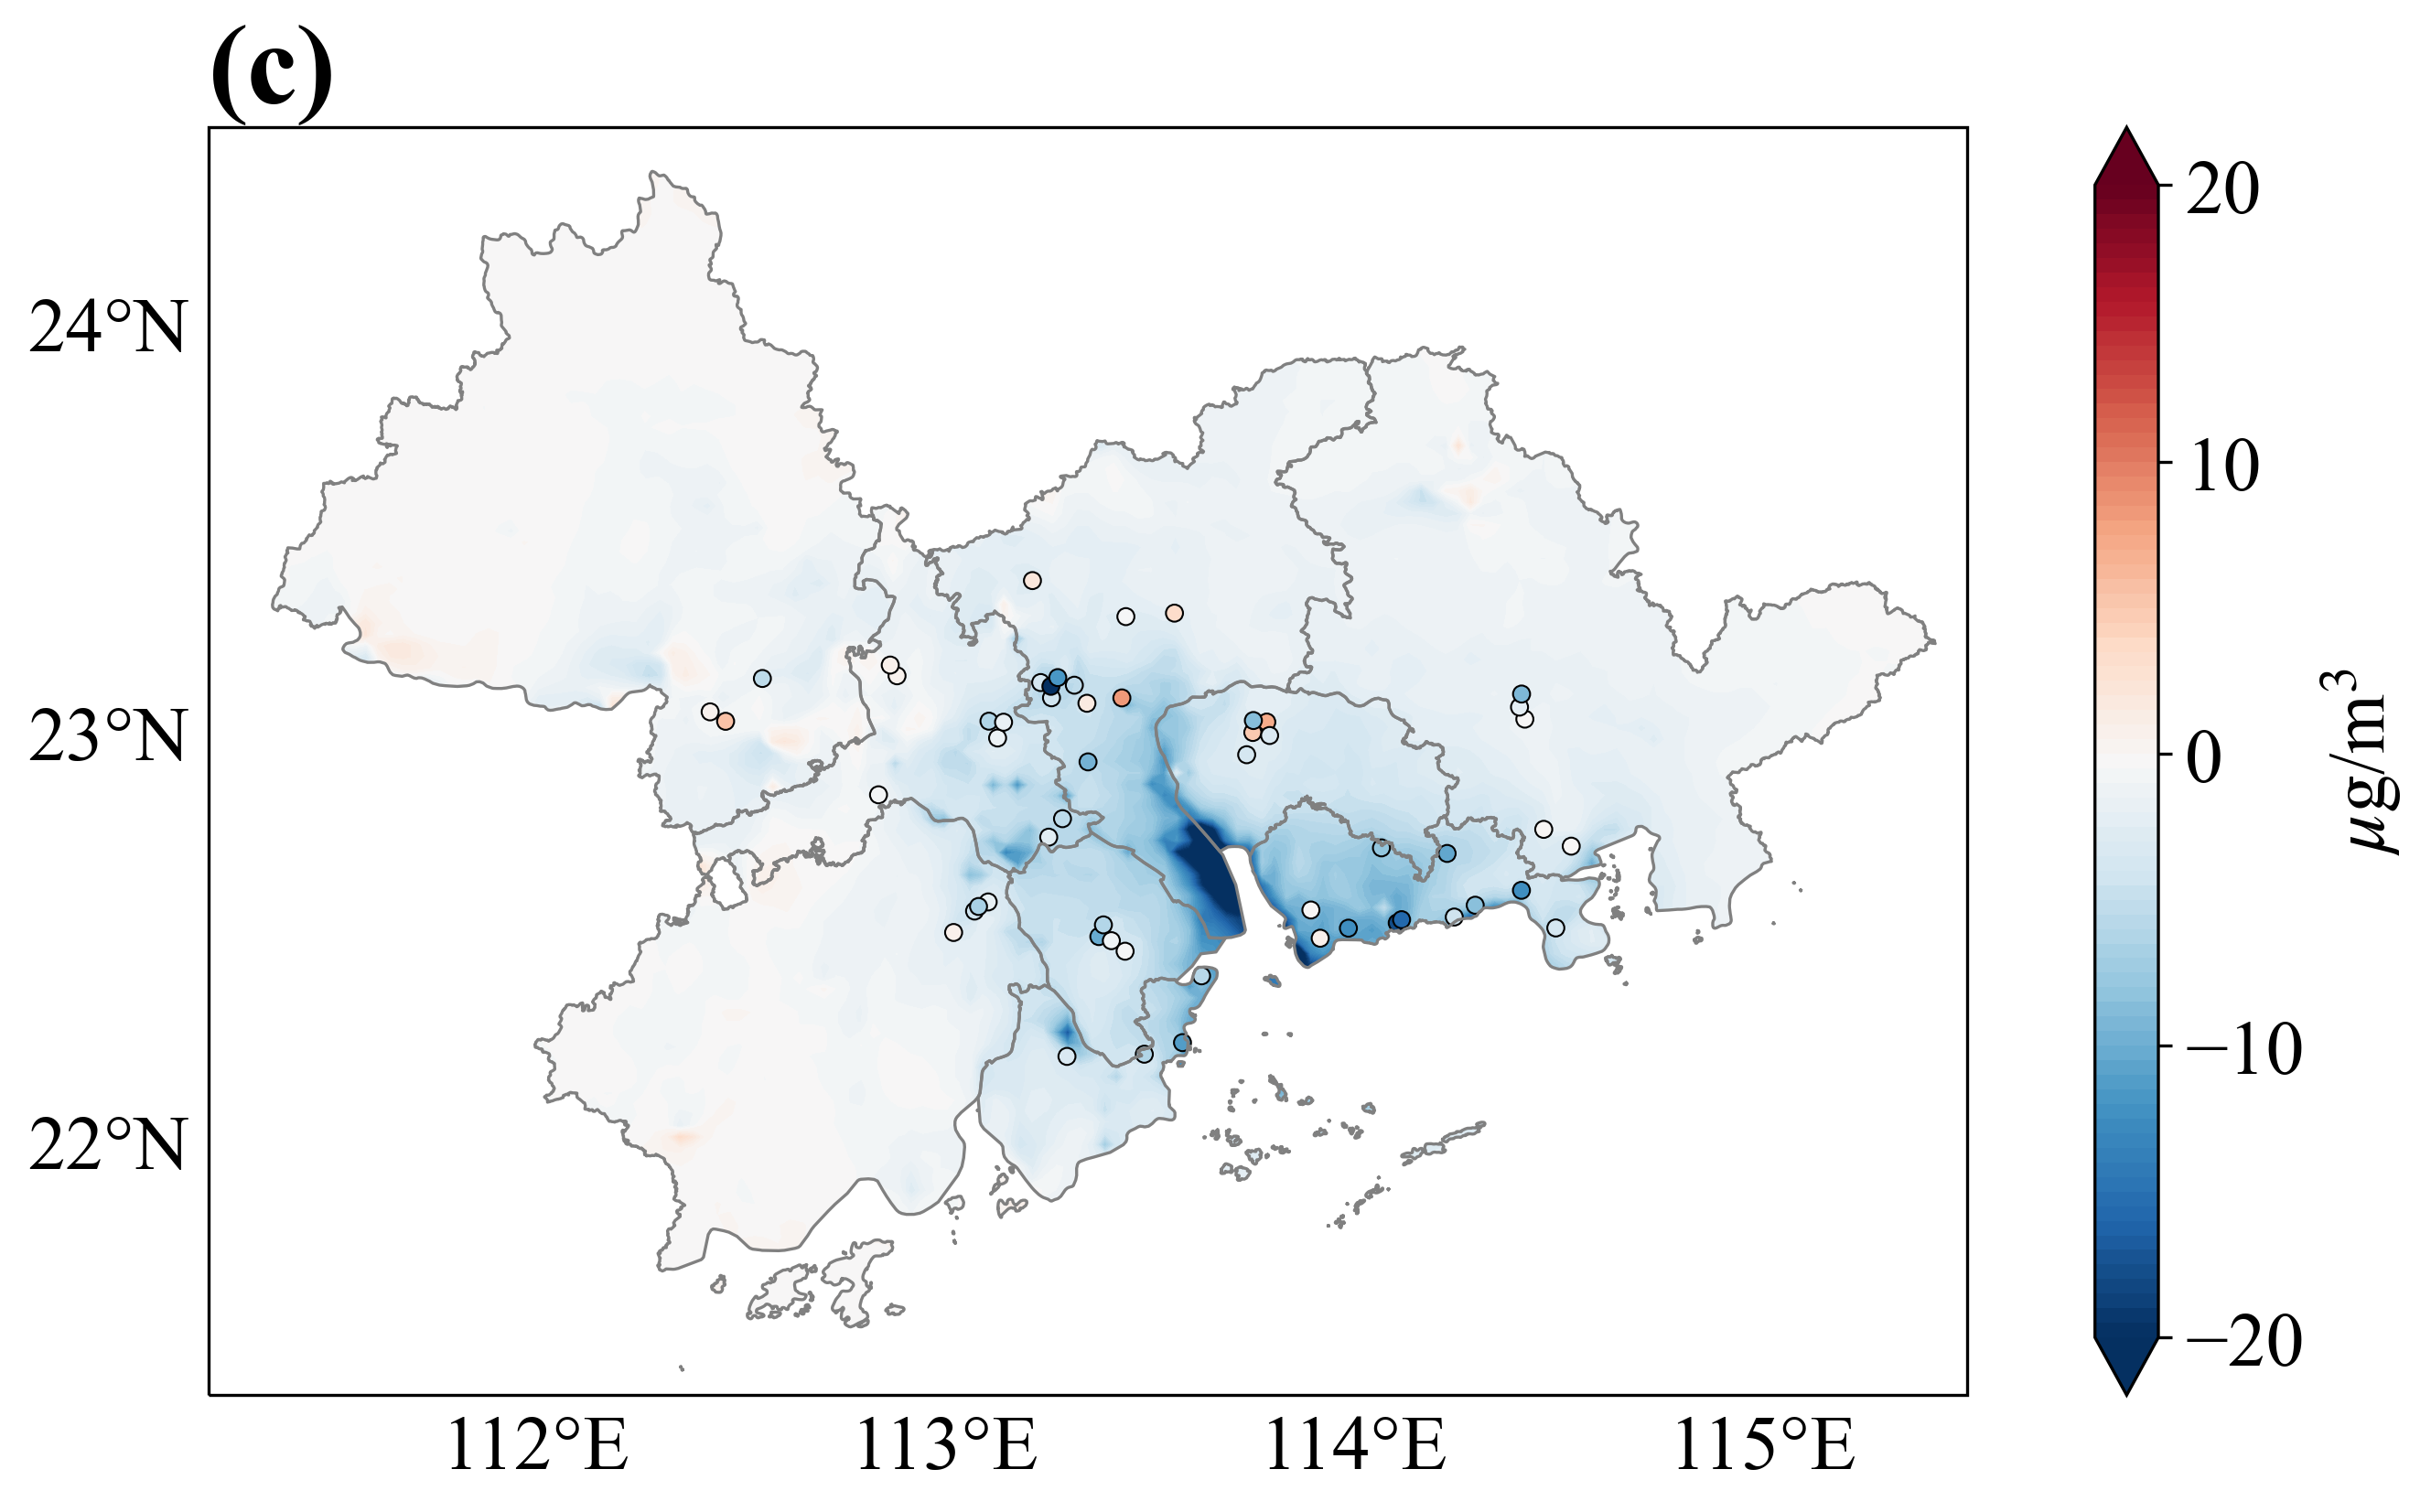

In [8]:
cmin = -20
cmax = 20
cmstep = 0.5
cbstep = 10

map_diff(sim_high, cmin, cmax, cmstep, cbstep,
              avg_sim_low, avg_sim_high,
              avg_obs_low,avg_obs_high,sitelon,sitelat,
              title='(c)', colorbar_label='$\mu$g/m$^3$')

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from matplotlib.colors import Normalize

from cnmaps import get_adm_maps, clip_quiver_by_map, clip_contours_by_map, draw_map
import geopandas as gpd
from shapely.ops import unary_union

from matplotlib import rcParams
config = {
    "font.family":'Times New Roman',
    "mathtext.fontset":'stix',
    "font.serif": ['SimSun'],
}
rcParams.update(config)


In [35]:
def map_diff(gridfile, cmin, cmax, cmstep, cbstep, 
                  data1_to_plot, data2_to_plot,
                  obs1_to_plot, obs2_to_plot, 
                  obslon, obslat,
                  mapcolor=None, title=None, colorbar_label=None,
                  outpath=None):
    
    lon = gridfile.longitude
    lat = gridfile.latitude
    contourf_ticks = np.arange(cmin, cmax, cmstep)
    colorbar_ticks = np.arange(cmin,cmax+0.01,cbstep)

    fig = plt.figure(figsize=(12, 6), dpi=300)
    ax = fig.subplots(1, 1, subplot_kw={'projection': ccrs.PlateCarree()})
    if mapcolor is not None:
        colormap = mapcolor
    else:
        colormap = 'RdBu_r'
    
    # =============================================
    # Defining map boundaries
    # =============================================
    
    cities = ['广州市', '佛山市', '深圳市', '东莞市', '珠海市', '中山市', '惠州市', '江门市', '肇庆市']
    multi_polygons = []

    for city in cities:
        polygon = get_adm_maps(city=city, record='first', only_polygon=True)
        multi_polygons.append(polygon)
        draw_map(polygon, color='gray', linewidth=0.8)

    map_polygon = unary_union(multi_polygons)

    gl = ax.gridlines(
        xlocs=np.arange(-180, 180 + 1, 1), ylocs=np.arange(-90, 90 + 1, 1),
        draw_labels=True, x_inline=False, y_inline=False,
        linewidth=0, linestyle='--', color='gray')
    gl.top_labels = False
    gl.right_labels = False
    gl.rotate_labels = False
    gl.xlabel_style = {'size': 30}
    gl.ylabel_style = {'size': 30}
    
    ax.set_extent([111.2, 115.5, 21.4, 24.5], ccrs.PlateCarree())

    # =============================================
    # Pollutants concentration & Mask map
    # =============================================

    cf = ax.contourf(lon, lat, data2_to_plot - data1_to_plot,
                     cmap=colormap,
                     levels=contourf_ticks, extend='both',
                     transform=ccrs.PlateCarree())

    clip_contours_by_map(cf, map_polygon)
    
    # =============================================
    # Observation stations scatter & Mask map
    # =============================================
    
    norm = Normalize(vmin=cmin, vmax=cmax)
    
    cs = ax.scatter(obslon,obslat,c=obs2_to_plot - obs1_to_plot,cmap=colormap,marker='o',s=20,
                    edgecolors='k',linewidths=0.5,norm=norm,transform=ccrs.PlateCarree())
    
    # =============================================
    # Defining title of the map and colorbar
    # =============================================

    if title is not None:
        ax.set_title(title, loc='left', fontdict={'fontsize': 40, 'fontweight': 'bold'})

    # fig.subplots_adjust(right=0.9)
    pos = fig.add_axes([0.8, 0.12, 0.03, 0.75])
    cbar = fig.colorbar(cf,cax=pos,orientation='vertical')
    cbar.set_ticks(colorbar_ticks)
    cbar.ax.tick_params(labelsize=30)
    if colorbar_label is not None:
        cbar.set_label(colorbar_label,fontsize=30)

    plt.show()
    
    if outpath is not None:
        fig.savefig(outpath, dpi=300, bbox_inches='tight')


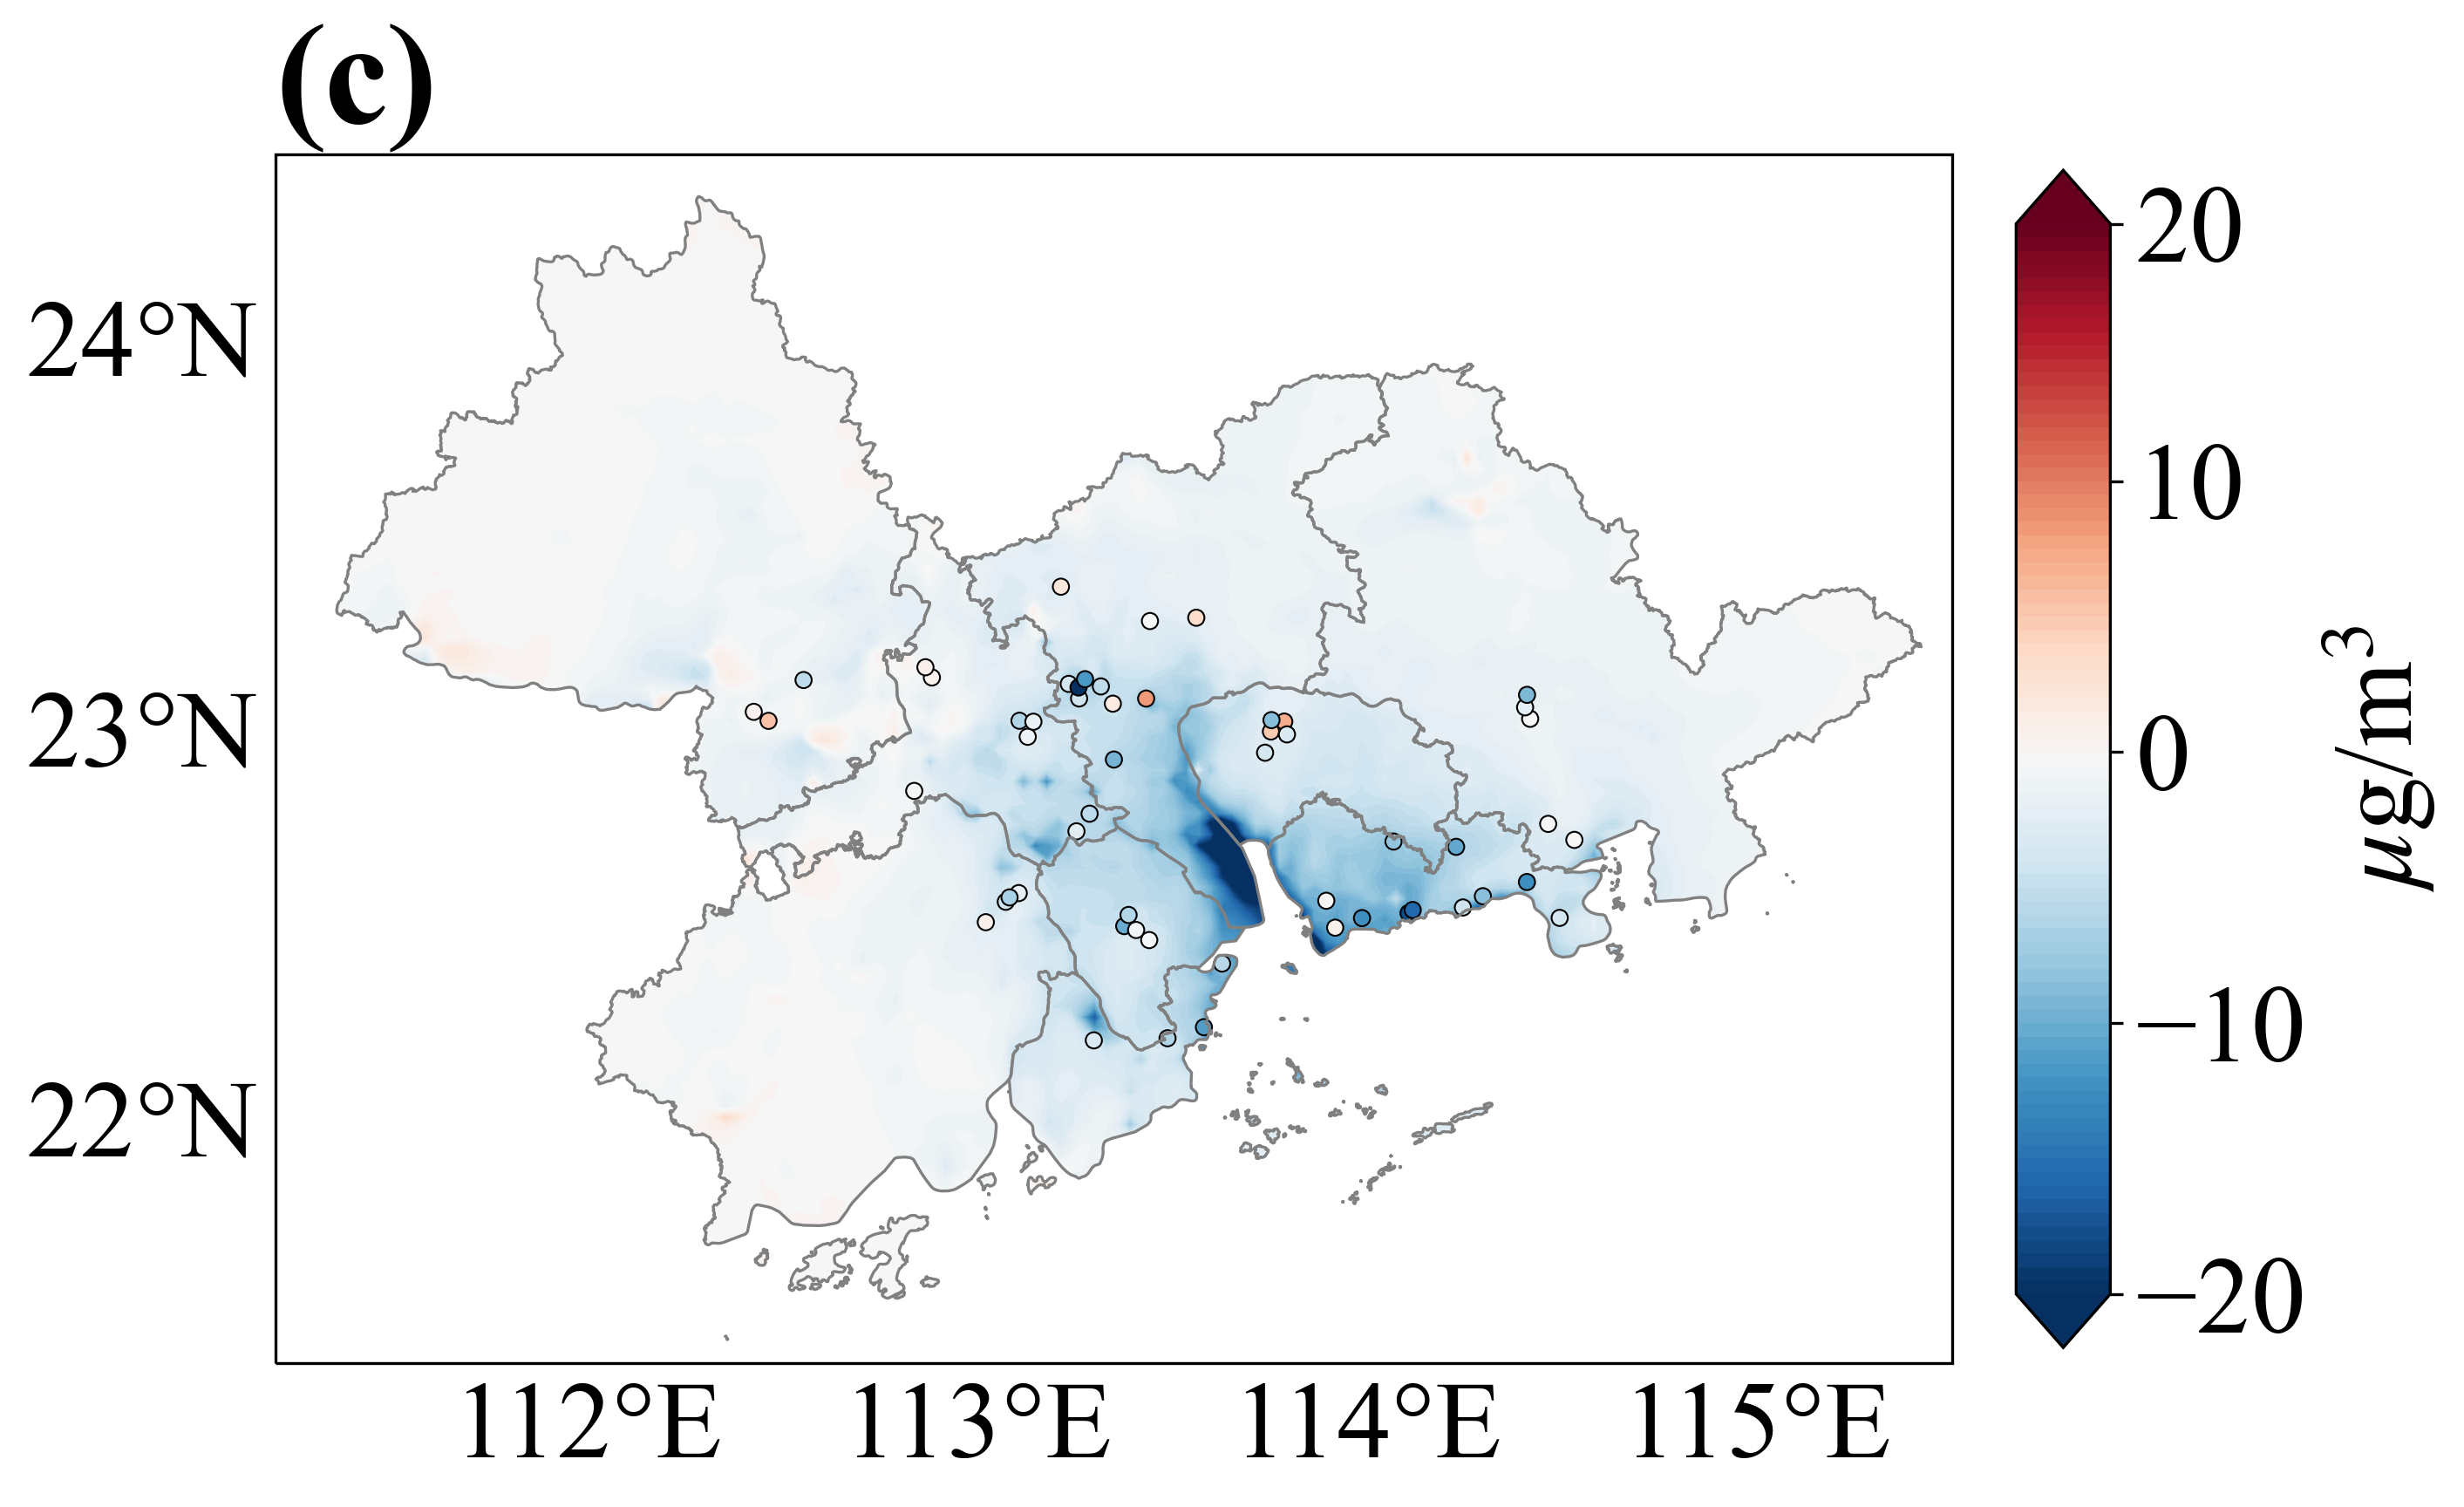

In [36]:
cmin = -20
cmax = 20
cmstep = 0.5
cbstep = 10

map_diff(sim_high, cmin, cmax, cmstep, cbstep,
              avg_sim_low, avg_sim_high,
              avg_obs_low,avg_obs_high,sitelon,sitelat,
              title='(c)', colorbar_label='$\mu$g/m$^3$')